In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from time_series_service import series_to_supervised

In [2]:
# Read and prepare data to linear regression model

df = pd.read_csv('generated/btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df.sort_values('DateTime')
df.set_index('DateTime',inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 2020-07-01 to 2021-06-26
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Negative  361 non-null    float64
 1   Neutral   361 non-null    float64
 2   Positive  361 non-null    float64
 3   Compound  361 non-null    float64
 4   Price     360 non-null    float64
dtypes: float64(5)
memory usage: 16.9+ KB


,Negative,Neutral,Positive,Compound,Price
DateTime,,,,,
2020-07-01,0.0,0.0,0.0,0.0,144.8
2020-07-02,0.0,0.0,0.0,0.0,18.0
2020-07-03,0.0,0.0,0.0,0.0,-67.3
2020-07-04,0.0,0.0,0.0,0.0,53.4
2020-07-05,0.0,0.0,0.0,0.0,-258.0


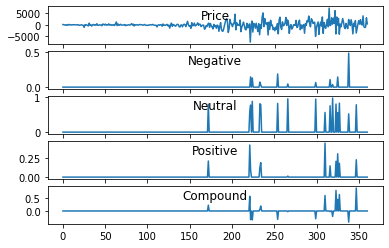

In [3]:
# Plot the time series of all features

columns_groups = [0,1,2,3,4]

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

i = 1
plt.figure()
for column_group in columns_groups:
    plt.subplot(len(columns_groups), 1, i)
    plt.plot(df.values[:, column_group])
    plt.title(df.columns[column_group], y=0.5, loc='center')
    i += 1
plt.show()

In [4]:
# Reframe the data so we can apply supervised learning techniques in a time series

n_days = 1
n_features = 5
n_obs = n_days * n_features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

reframed = series_to_supervised(scaled, n_days, 1)
reframed = reframed.drop(reframed.columns[-4:], axis=1)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.517534,0.0,0.0,0.0,0.326643,0.508997
2,0.508997,0.0,0.0,0.0,0.326643,0.503255
3,0.503255,0.0,0.0,0.0,0.326643,0.511381
4,0.511381,0.0,0.0,0.0,0.326643,0.490417
5,0.490417,0.0,0.0,0.0,0.326643,0.513373


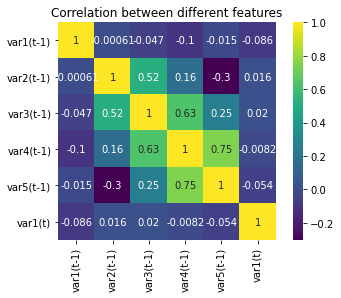

In [5]:
# Plot correlation matrix

correlation = reframed.corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different features')
plt.show();

In [6]:
# Split train and test data

non_zero_condition = reframed['var5(t-1)'].round(4) != 0.3266

zeros_df = reframed[~non_zero_condition]
non_zeros_df = reframed[non_zero_condition]

zeros_train_size = 0.7
non_zeros_train_size = 0.75

zeros_n_train_days = int(len(zeros_df)*zeros_train_size)
zeros_n_test_days =len(zeros_df) - zeros_n_train_days
non_zeros_n_train_days = int(len(non_zeros_df)*non_zeros_train_size)
non_zeros_n_test_days = len(non_zeros_df) - non_zeros_n_train_days

non_zero_test_step = int(len(non_zeros_df)/non_zeros_n_test_days)
zero_test_step = int(len(zeros_df)/zeros_n_test_days)

non_zero_test = non_zeros_df[::non_zero_test_step]
non_zero_train = pd.merge(non_zeros_df,non_zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

zero_test = zeros_df[::zero_test_step]
zero_train = pd.merge(zeros_df,zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

train = shuffle(pd.concat((non_zero_train, zero_train))).values
test = shuffle(pd.concat((non_zero_test, zero_test))).values

print(train.shape)

train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(239, 6)
(239, 1, 5) (239,) (120, 1, 5) (120,)


Epoch 1/100
48/48 - 2s - loss: 0.0082 - val_loss: 0.0179
Epoch 2/100
48/48 - 0s - loss: 0.0072 - val_loss: 0.0167
Epoch 3/100
48/48 - 0s - loss: 0.0065 - val_loss: 0.0156
Epoch 4/100
48/48 - 0s - loss: 0.0054 - val_loss: 0.0149
Epoch 5/100
48/48 - 0s - loss: 0.0048 - val_loss: 0.0147
Epoch 6/100
48/48 - 0s - loss: 0.0048 - val_loss: 0.0143
Epoch 7/100
48/48 - 0s - loss: 0.0045 - val_loss: 0.0144
Epoch 8/100
48/48 - 0s - loss: 0.0045 - val_loss: 0.0144
Epoch 9/100
48/48 - 0s - loss: 0.0045 - val_loss: 0.0140
Epoch 10/100
48/48 - 0s - loss: 0.0043 - val_loss: 0.0136
Epoch 11/100
48/48 - 0s - loss: 0.0043 - val_loss: 0.0135
Epoch 12/100
48/48 - 0s - loss: 0.0043 - val_loss: 0.0134
Epoch 13/100
48/48 - 0s - loss: 0.0041 - val_loss: 0.0128
Epoch 14/100
48/48 - 0s - loss: 0.0041 - val_loss: 0.0127
Epoch 15/100
48/48 - 0s - loss: 0.0040 - val_loss: 0.0129
Epoch 16/100
48/48 - 0s - loss: 0.0041 - val_loss: 0.0122
Epoch 17/100
48/48 - 0s - loss: 0.0038 - val_loss: 0.0122
Epoch 18/100
48/48 - 0s

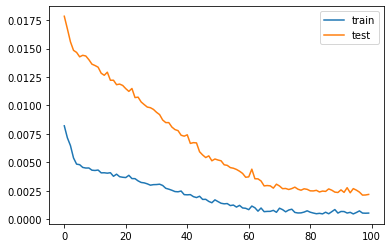

In [7]:
# Create the LSTM model, train it and plot the value loss

model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# Make predictions

predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days * n_features))

inv_predictions = np.concatenate((predictions, test_X[:, -4:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

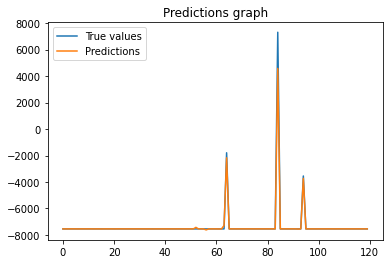

In [9]:
# Plot Results

plt.plot(inv_y, label="True values")
plt.plot(inv_predictions, label="Predictions")
plt.title("Predictions graph")
plt.legend(loc="upper left")

plt.show()

In [10]:
# Print the results

mse = mean_squared_error(inv_y, inv_predictions)
r2 = r2_score(inv_y, inv_predictions)
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

Coefficient of Determination  (R2): 0.9707652442444178
Mean Squared Error (MSE): 64478.41288100638
Root Mean Square Error: 253.926


In [11]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions,'actual':inv_y})
df_sol.to_csv('generated/predictions_lstm.csv')